In [1]:
from skimage import io, transform, color
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from skimage.registration import optical_flow_tvl1, optical_flow_ilk, phase_cross_correlation

In [21]:
%matplotlib notebook

In [3]:
# crop the boarders of an image
def crop_border(img, border_size):
    if img.ndim == 2:  # Grayscale image
        y, x = img.shape
        return img[border_size:y-border_size, border_size:x-border_size]
    elif img.ndim == 3:  # RGB or multi-channel image
        y, x, _ = img.shape
        return img[border_size:y-border_size, border_size:x-border_size]
    else:
        raise ValueError("Unsupported image dimensions")

In [4]:
# image_path = '/Users/sichen/Box Sync/projects/2024-summer-Sandoval/rad_damage_study'

# #reading tiff
# smpl5_f1_name = 'Uncoated_Sample5_Frame1.tif'
# smpl5_f300_name = 'Uncoated_Sample5_Frame300.tif'
# smpl6_f1_name = 'Coated_Sample6_Frame1.tif'
# smpl6_f900_name = 'Coated_Sample6_Frame900.tif'

In [5]:
# # Load the images

# smpl6_f1_img = io.imread(image_path+'/'+smpl6_f1_name)
# smpl6_f900_img = io.imread(image_path+'/'+smpl6_f900_name)

In [6]:
# Load the images
filepath = ['C:/Users/maz_b/PY/Uncoated_Sample5_Frame1.tif', 'C:/Users/maz_b/PY/Uncoated_Sample5_Frame300.tif']


smpl6_f1_img = io.imread(filepath[0])
smpl6_f900_img = io.imread(filepath[1])

In [7]:
len(smpl6_f1_img.shape), smpl6_f1_img.dtype, np.min(smpl6_f1_img), np.max(smpl6_f1_img)

(2, dtype('uint16'), 5906, 37124)

<IPython.core.display.Javascript object>


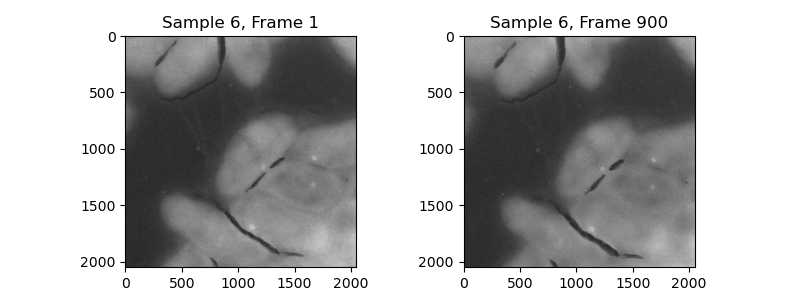

Text(0.5, 1.0, 'Sample 6, Frame 900')

In [22]:
# Display the two original images

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
im0 = ax0.imshow(smpl6_f1_img, cmap='gray')
ax0.set_title("Sample 6, Frame 1")
# plt.colorbar(im0)

im1 = ax1.imshow(smpl6_f900_img, cmap='gray')
ax1.set_title("Sample 6, Frame 900")
# plt.colorbar(im1)

In [15]:
########## normalization ########## seems to cause issues for optical flow via both algorithms

# smpl6_f1_img_n = (smpl6_f1_img - smpl6_f1_img.min()) / (smpl6_f1_img.max() - smpl6_f1_img.min())
# smpl6_f900_img_n = (smpl6_f900_img - smpl6_f900_img.min()) / (smpl6_f900_img.max() - smpl6_f900_img.min())

In [16]:
########## without normalization ##########

smpl6_f1_img_n = smpl6_f1_img 
smpl6_f900_img_n = smpl6_f900_img 

In [17]:
smpl6_f1_img_n.min(), smpl6_f1_img_n.max(), smpl6_f900_img_n.min(), smpl6_f900_img_n.max()

(5906, 37124, 5968, 35170)

In [18]:
########## phase cross correlation for global registration ########## 

shift, error, diffphase = phase_cross_correlation(smpl6_f1_img_n, smpl6_f900_img_n)
print(f"Shift in X: {shift[1]}")
print(f"Shift in Y: {shift[0]}")

Shift in X: 0.0
Shift in Y: -13.0


In [19]:
########## rigid transformation to align the two image ##########

rigid_shift = transform.EuclideanTransform(translation=(-shift[1],-shift[0]))
smpl6_f900_img_n_shift = transform.warp(smpl6_f900_img_n, rigid_shift)

<IPython.core.display.Javascript object>


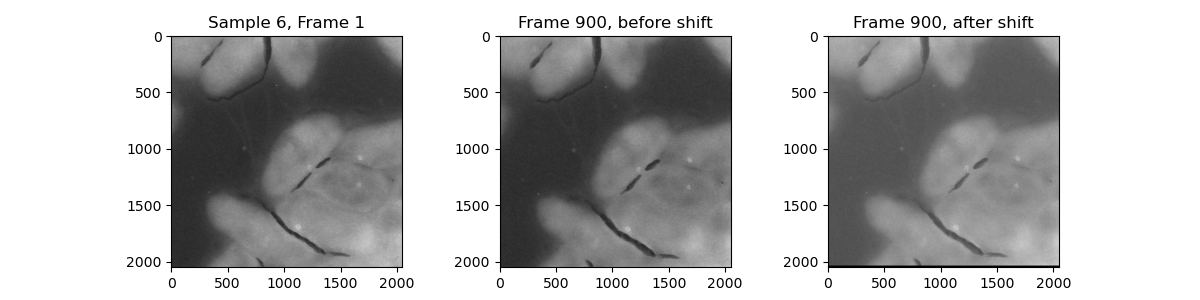

Text(0.5, 1.0, 'Frame 900, after shift')

In [23]:
# Display f1, and f900, before and after the shift

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3))
ax0.imshow(smpl6_f1_img_n, cmap='gray')
ax0.set_title("Sample 6, Frame 1")

ax1.imshow(smpl6_f900_img_n, cmap='gray')
ax1.set_title("Frame 900, before shift")

ax2.imshow(smpl6_f900_img_n_shift, cmap='gray')
ax2.set_title("Frame 900, after shift")

In [15]:
# fig.savefig(image_path+'/'+'sample_6_crosscorr')
# print('Figure saved')

In [25]:
smpl6_f1_crop = crop_border(smpl6_f1_img_n, 28)
smpl6_f900_crop = crop_border(smpl6_f900_img_n_shift, 28)

In [26]:
smpl6_f1_crop.min(), smpl6_f1_crop.max(), smpl6_f1_img_n.max(), smpl6_f900_crop.min(), smpl6_f900_crop.max()

(5906, 37124, 37124, 0.09106584267948424, 0.5366598001068131)

<IPython.core.display.Javascript object>


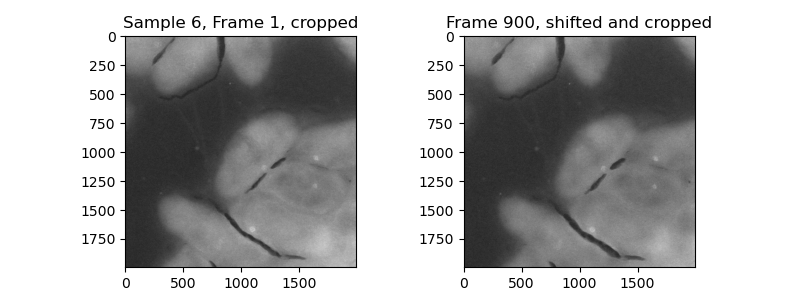

Text(0.5, 1.0, 'Frame 900, shifted and cropped')

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.imshow(smpl6_f1_crop, cmap='gray')
ax0.set_title("Sample 6, Frame 1, cropped")

ax1.imshow(smpl6_f900_crop, cmap='gray')
ax1.set_title("Frame 900, shifted and cropped")

In [28]:
########## Calculate the optical flow for local distortion ##########
# the two images need normalization before this operation

# v1,u1 = optical_flow_tvl1(smpl6_f1_crop, smpl6_f900_crop)
v1,u1 = optical_flow_ilk(smpl6_f1_crop, smpl6_f900_crop)


In [29]:
# Use the estimated optical flow for registration

nr, nc = smpl6_f1_crop.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')

smpl6_f900_crop_warp = transform.warp(smpl6_f900_crop, np.array([row_coords + v1, col_coords + u1]), mode='edge')

In [30]:
np.min(smpl6_f1_crop), np.max(smpl6_f1_crop), np.min(smpl6_f900_crop), np.max(smpl6_f900_crop), np.min(smpl6_f900_crop_warp), np.max(smpl6_f900_crop_warp) 

(5906,
 37124,
 0.09106584267948424,
 0.5366598001068131,
 0.09978564235351796,
 0.49931148143773385)

In [31]:
# Normalization for forming RGB images to display the difference

smpl6_f1_crop = (smpl6_f1_crop - smpl6_f1_crop.min()) / (smpl6_f1_crop.max() - smpl6_f1_crop.min())
smpl6_f900_crop = (smpl6_f900_crop - smpl6_f900_crop.min()) / (smpl6_f900_crop.max() - smpl6_f900_crop.min())
smpl6_f900_crop_warp_n = (smpl6_f900_crop_warp - smpl6_f900_crop_warp.min()) / (smpl6_f900_crop_warp.max() - smpl6_f900_crop_warp.min())

In [32]:
np.min(smpl6_f1_crop), np.max(smpl6_f1_crop), np.min(smpl6_f900_crop), np.max(smpl6_f900_crop), np.min(smpl6_f900_crop_warp), np.max(smpl6_f900_crop_warp) 

(0.0, 1.0, 0.0, 1.0, 0.09978564235351796, 0.49931148143773385)

<IPython.core.display.Javascript object>


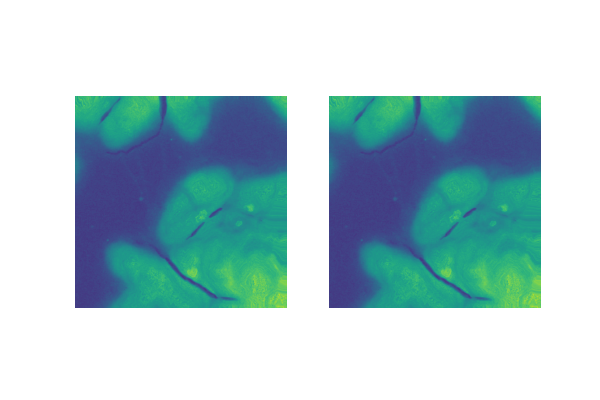

In [33]:
# Display

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 4))

ax0.imshow(smpl6_f900_crop_warp)
ax0.set_title("")
ax0.set_axis_off()

ax1.imshow(smpl6_f900_crop_warp_n)
ax1.set_title("")
ax1.set_axis_off()

In [25]:
# Build an RGB image with the sequence after global registration

seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = smpl6_f900_crop
seq_im[..., 1] = smpl6_f1_crop
seq_im[..., 2] = smpl6_f1_crop

In [26]:
# Build an RGB image with the registered sequence

reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = smpl6_f900_crop_warp_n
reg_im[..., 1] = smpl6_f1_crop
reg_im[..., 2] = smpl6_f1_crop

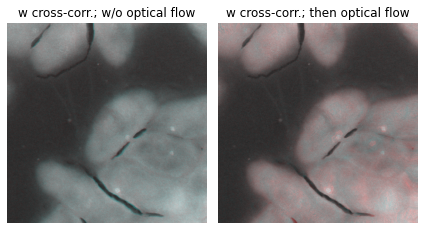

In [27]:
# Display

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 4))

ax0.imshow(seq_im)
ax0.set_title("w cross-corr.; w/o optical flow")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("w cross-corr.; then optical flow")
ax1.set_axis_off()

fig.tight_layout()

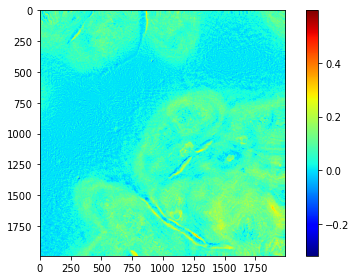

In [32]:
# plt.figure()

# plt.imshow(smpl6_f900_crop_warp_n-smpl6_f900_crop,cmap='jet',)

# plt.colorbar()

# plt.tight_layout()

In [33]:
# fig.savefig(image_path+'/'+'sample_6_crosscorr_of_tvl1_none_norm_input')
# print('Figure saved')

In [34]:
# Compute flow magnitude

norm = np.sqrt(u1**2 + v1**2)

In [35]:
# Threshold ( e.g. 5 pixel )
threshold = 6
mask = np.where (norm > threshold, 1, 0)
u1_filtered = u1 * mask
v1_filtered = v1 * mask

In [37]:
# Quiver plot arguments

nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = smpl6_f1_crop.shape
step = max(nl // nvec, nc // nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u = u1_filtered[::step, ::step] 
v = v1_filtered[::step, ::step]

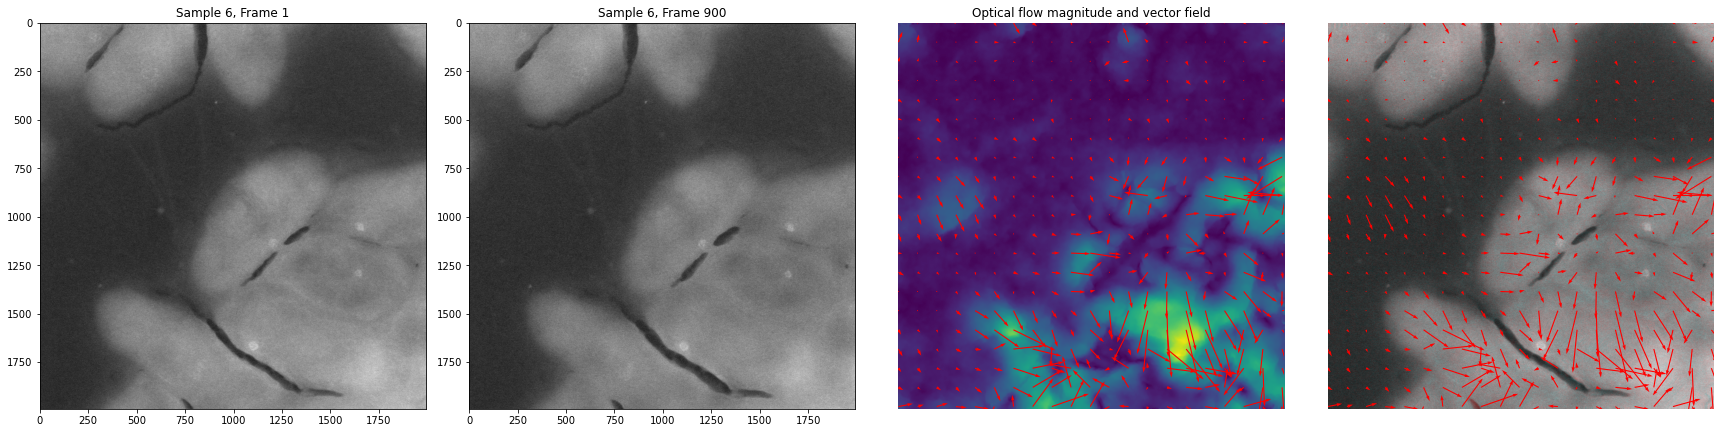

In [54]:
# Display

fig, ax = plt.subplots(1, 4, figsize=(24, 6))

ax[0].imshow(smpl6_f1_crop, cmap='gray')
ax[0].set_title("Sample 6, Frame 1")

ax[1].imshow(smpl6_f900_crop, cmap='gray')
ax[1].set_title("Sample 6, Frame 900")

ax[2].imshow(norm)
ax[2].quiver(x, y, u, v, color='r', units='dots', angles='xy', scale_units='xy', lw=3)
ax[2].set_title("Optical flow magnitude and vector field")
ax[2].set_axis_off()

ax[3].imshow(reg_im, cmap='gray')
ax[3].quiver(x, y, u, v, color='r', units='dots', angles='xy', scale_units='xy', lw=3)
ax[3].set_axis_off()

fig.tight_layout()

plt.show()

In [55]:
# fig.savefig(image_path+'/'+'sample_6_quiver_tvl1_none_norm_input')
# print('Figure saved')

In [56]:
norm_flat = norm.flatten()

In [57]:
norm_flat.shape

(3968064,)

Text(0, 0.5, 'Frequency')

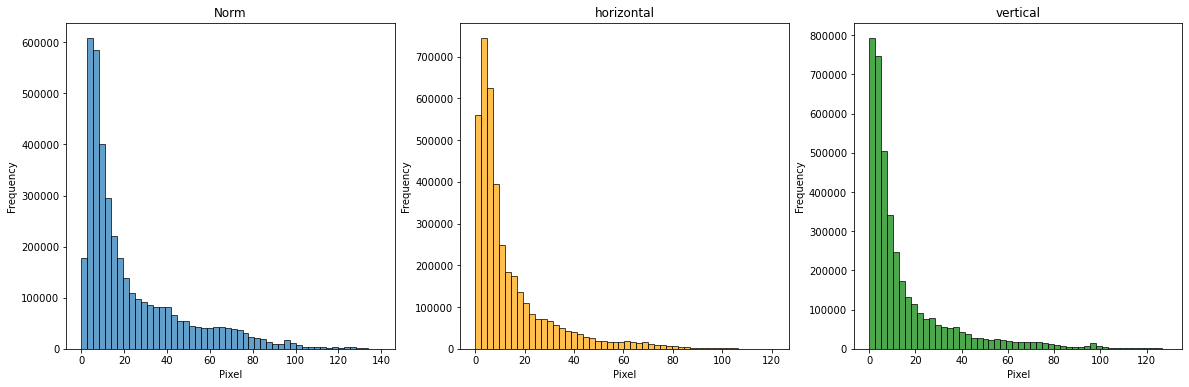

In [58]:
# histograph of norm, u1, v1
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].hist(norm_flat, bins=50, edgecolor='black', alpha=0.7)
axs[0].set_title('Norm')
axs[0].set_xlabel('Pixel')
axs[0].set_ylabel('Frequency')

axs[1].hist(abs(u1.flatten()), bins=50, edgecolor='black', alpha=0.7, color='orange')
axs[1].set_title('horizontal')
axs[1].set_xlabel('Pixel')
axs[1].set_ylabel('Frequency')

axs[2].hist(abs(v1.flatten()), bins=50, edgecolor='black', alpha=0.7, color='green')
axs[2].set_title('vertical')
axs[2].set_xlabel('Pixel')
axs[2].set_ylabel('Frequency')

In [40]:
# fig.savefig(image_path+'/'+'sample_6_freq_tvl1_none_norm_input')
# print('Figure saved')

In [38]:
# Reduce the size of image, and convert to the same data type uint8

# binning_factor = 10

# smpl5_f1_img = transform.downscale_local_mean(smpl5_f1_img, (binning_factor, binning_factor, 1))
# smpl5_f1_img = np.clip (smpl5_f1_img)
# smpl5_f1_img = smpl5_f1_img.astype(np.uint8)

# smpl5_f300_img = transform.downscale_local_mean(smpl5_f300_img,(binning_factor, binning_factor, 1))
# smpl5_f300_img = np.clip (smpl5_f300_img)
# smpl5_f300_img = smpl5_f300_img.astype(np.uint8)

In [39]:
# Convert RGBA to gray scale, because optical flow only works on gray-scale images

# smpl5_f1_img_RGB = smpl5_f1_img[:, :, :3]
# smpl5_f1_img_g = color.rgb2gray(smpl5_f1_img_RGB)
# smpl5_f300_img_RGB = smpl5_f300_img[:, :, :3]
# smpl5_f300_img_g = color.rgb2gray(smpl5_f300_img_RGB)